In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500

In [2]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

### Задача сегментации клиентов!

Сюжет: автомобильная компания провела внутреннее маркетинговое исследование и выявила, что клиенты делятся на 4 различных сегмента.

В зависимости от принадлежности к той или иной группе, различным клиентам предлагаются различные пакеты услуг, приставляются особого рода менеджеры; на этих клиентов воздействуют отличающимися друг от друга маркетинговыми интсрументами и т.д.

Данная политика показала себя успешной. Счастье клиентов стало расти, ровно как и продажи!

Теперь организация планирует выйти на новый рынок в соседнем регионе. Чтобы сразу показать конкурентам, где раки зимуют, управляющие планируют построить модель, определяющую, к какому сегменту относится тот или иной клиент. Это позволит на новом рынке лучше прощупать почву и быстрее найти нужный язык с новыми покупателями.

В качестве данных - информация о уже текущих сегментированных клиентах (на внутреннем рынке).

Сегменты бывают: A, B, C, D

Тогда задача, которую планируем решать - множественная классификация!



### Загрузка данных

Описание колонок:

1. **ID** - уникальный идентификатор клиента
2. **Gender** - пол
3. **Ever_Married** - статус замужества
4. **Age** - возраст
5. **Graduated** - дипломирован ли?
6. **Profession** - сфера деятельности
7. **Work_Experience** - опыт работы (в годах)
8. **Spending_Score** - уровень затрат
9. **Family_Size** - количество членов семьи
10. **Var_1** - анонимная категория клиента
11. **Segmentation** - сегмент клиента

**Наша целевая переменная - сегмент клиента.**

In [3]:
df = pd.read_csv("segmentation_data.csv")

In [8]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### Замена индекса

In [5]:
df.shape

(8068, 11)

In [7]:
df=df.set_index("ID")

In [22]:
df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,8068.000000
mean,43.466906,2.614631,2.850123
std,16.711696,3.227961,1.499278
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,2.850123
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


### Пропущенные значения

In [43]:
df.isna().sum()

,0
Gender,0
Ever_Married,0
Age,0
Graduated,0
Profession,0
Work_Experience,0
Spending_Score,0
Family_Size,0
Var_1,0
Segmentation,0


<Axes: ylabel='Family_Size'>

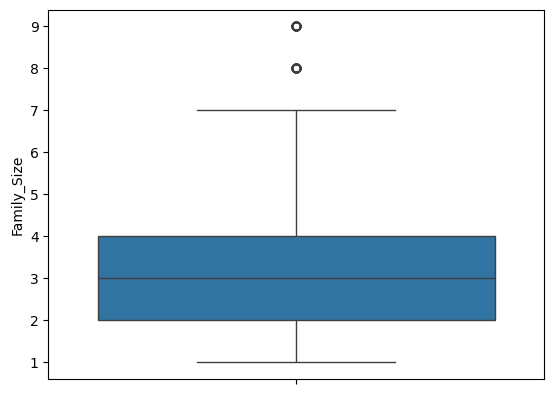

In [19]:
sns.boxplot(df["Family_Size"])

In [14]:
copy = df.copy()

In [21]:
df["Family_Size"] = df["Family_Size"].fillna(df[df["Family_Size"] <= 10]["Family_Size"].mean())

In [30]:
df["Var_1"] = df["Var_1"].fillna(df["Var_1"].value_counts().index[0])

In [29]:
df["Var_1"].value_counts()

,count
Var_1,
Cat_6,5238
Cat_4,1089
Cat_3,822
Cat_2,422
Cat_7,203
Cat_1,133
Cat_5,85


### Пропуски в признаках

Work_experience, Family_size, Ever_married, Graduated, Profession

In [41]:
choice = pd.Series(['Yes','No'])
def fillna__(x):
  if pd.isna(x) == True:
    string = pd.Series.sample(choice, weights=[0.62,0.38]).iloc[0]
    return string
  else:
    return x

In [45]:
5010/8068

0.6209717402082301

In [44]:
df["Graduated"].value_counts()

,count
Graduated,
Yes,5010
No,3058


In [42]:
df["Graduated"] = df["Graduated"].apply(fillna__)

#### Корреляция цифровых признаков

<Axes: >

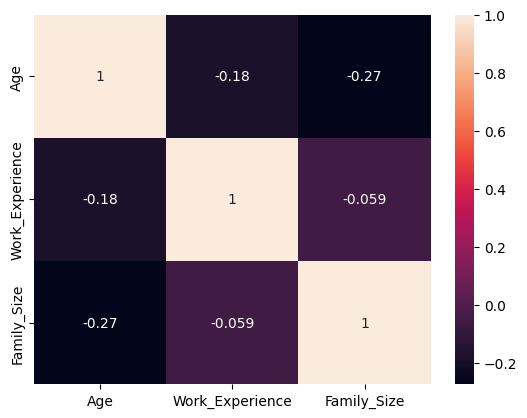

In [46]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [47]:
numerical = df.describe().columns

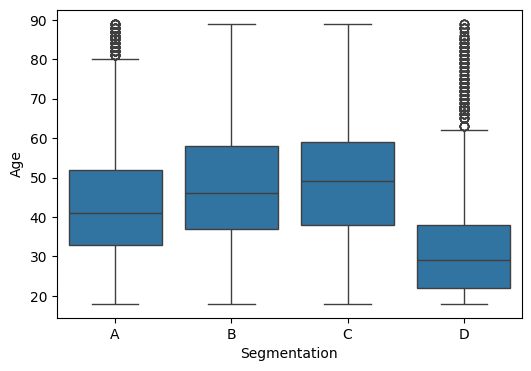

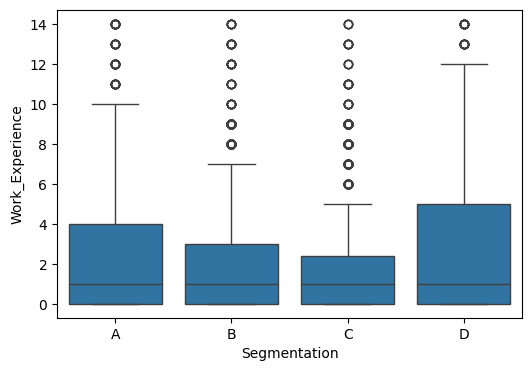

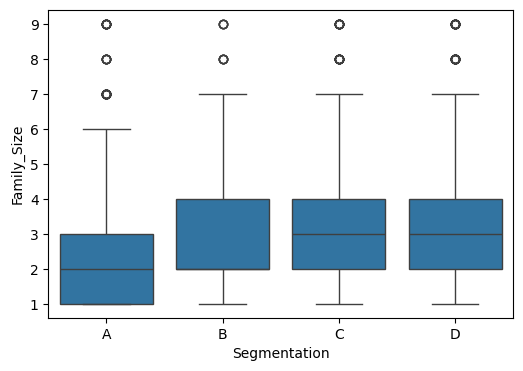

In [48]:
for i in numerical:
  fig = plt.figure()
  fig.set_size_inches(6, 4)
  sns.boxplot(y=i, x=df['Segmentation'].astype('category'), data=df)
  plt.show()

#### Графики с распределением каждого катеригориального признака относительно таргета

In [49]:
categorical = df.describe(include='object').columns

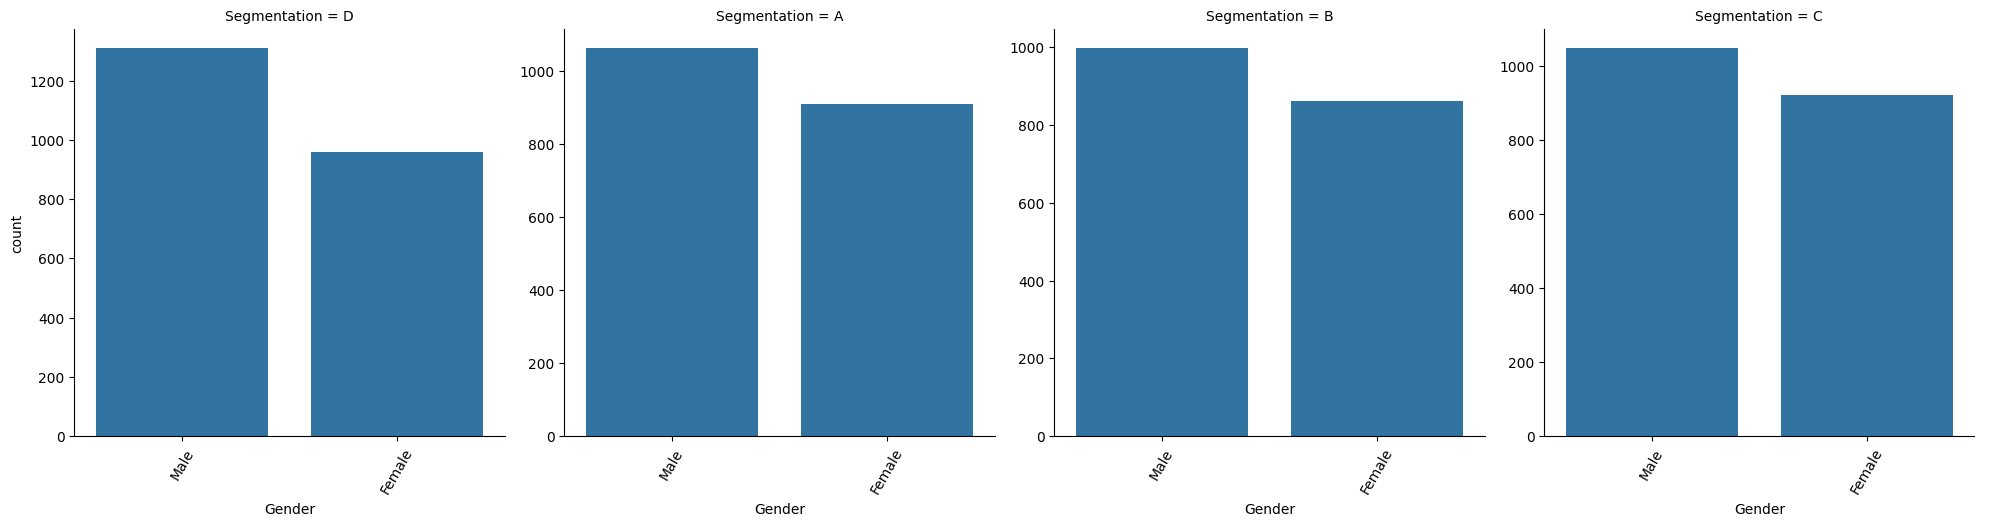

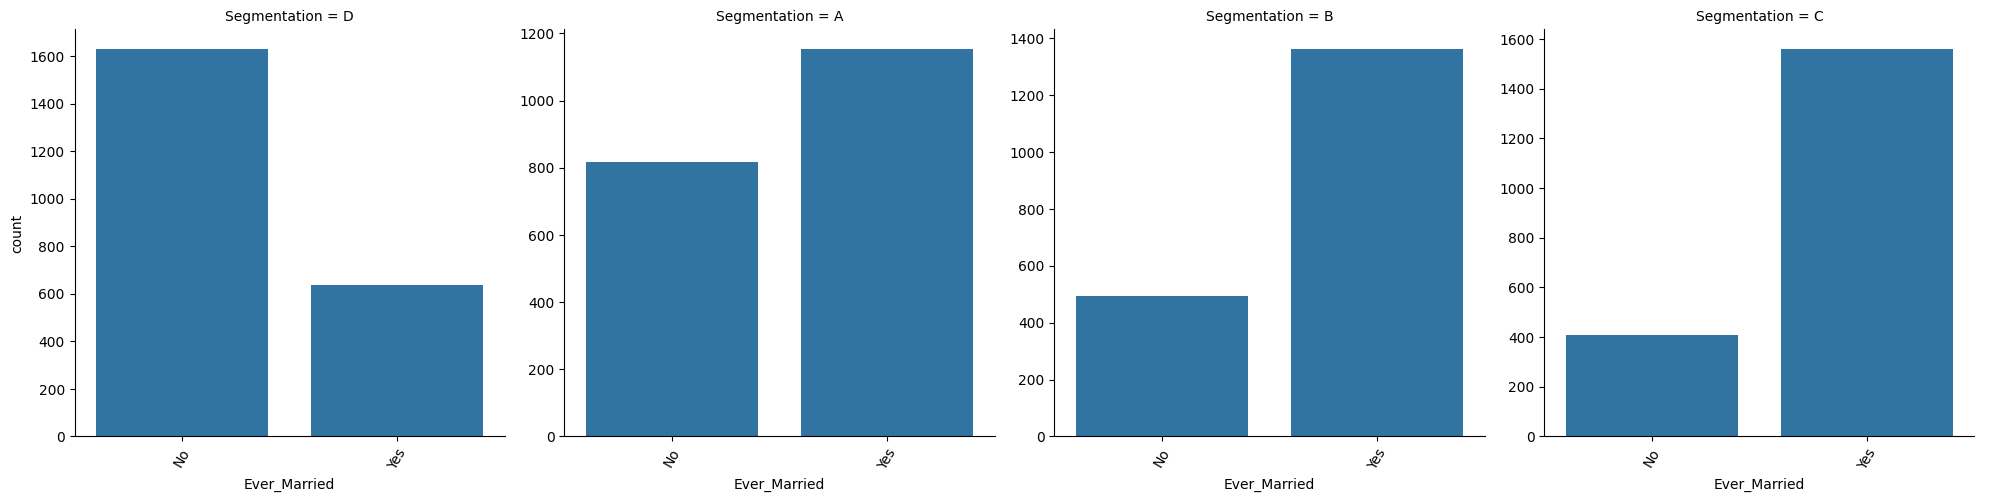

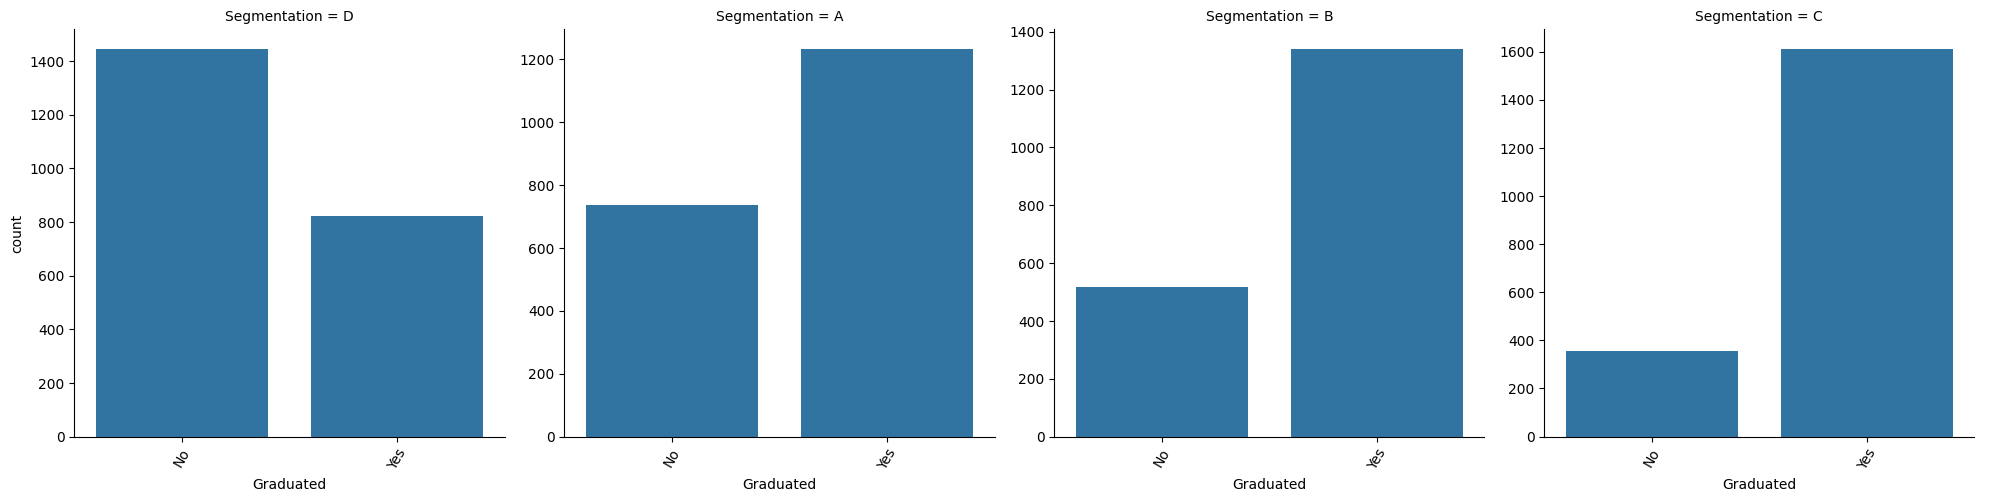

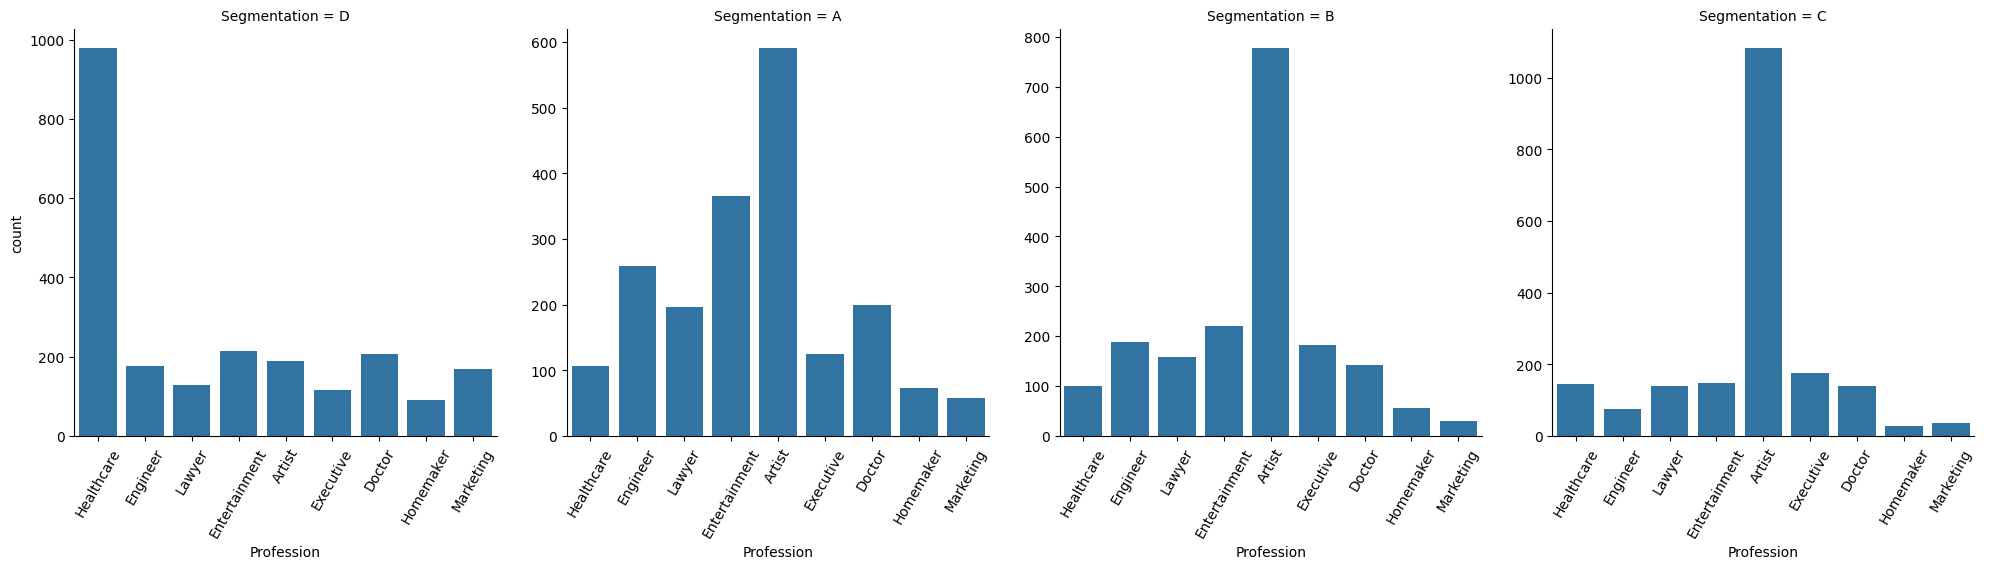

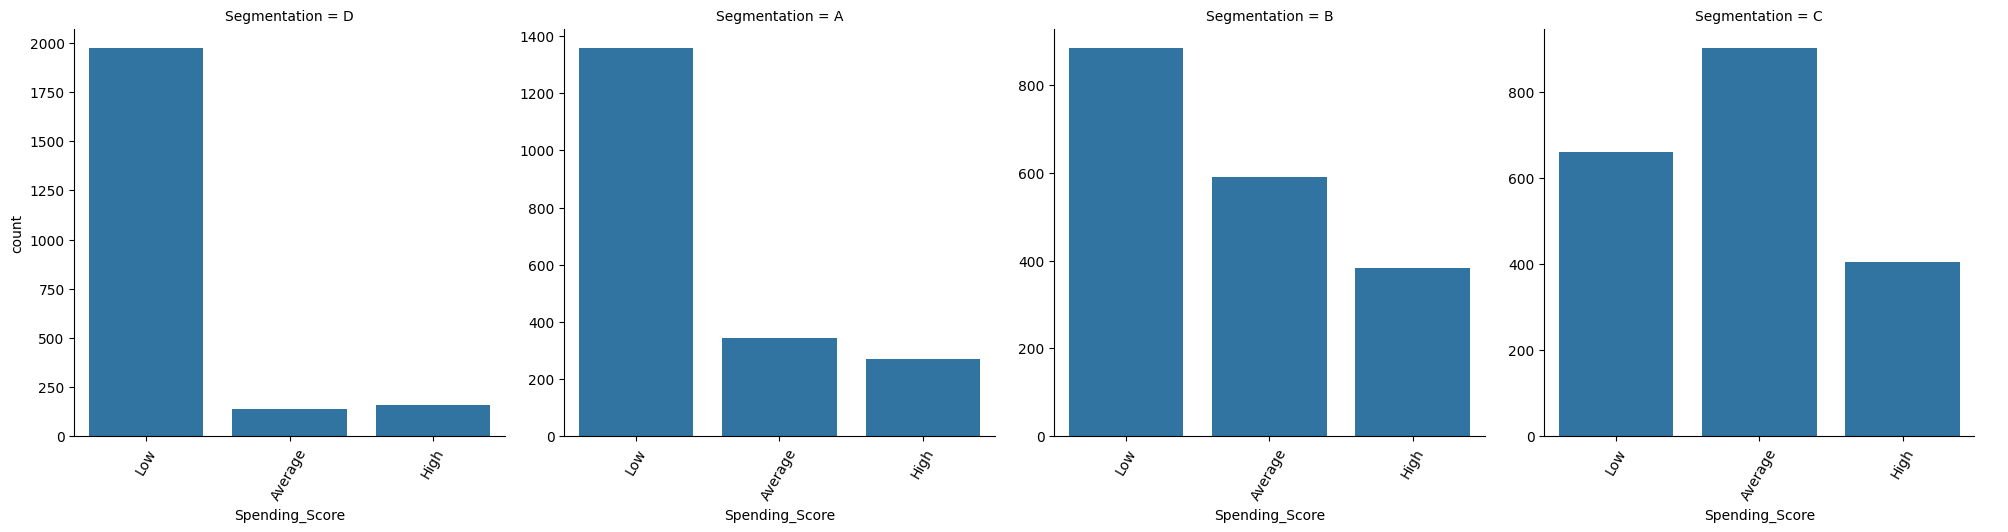

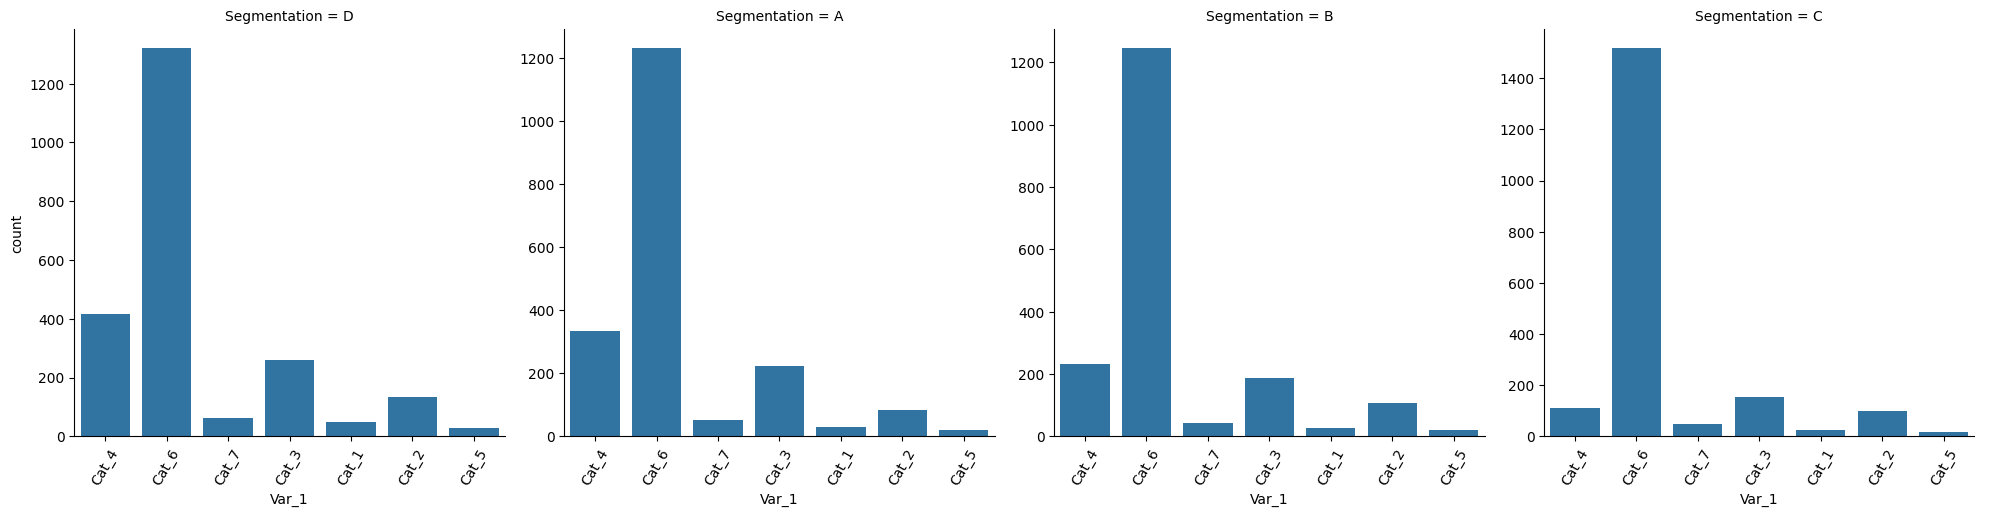

In [50]:
for col in categorical:
    if col != 'Segmentation':
        g = sns.catplot(x=col, kind='count', col='Segmentation', data=df, sharey=False)
        g.set_xticklabels(rotation=60)

### Закодируем категориальные фичи!

Аналог Счетчиков для multiclass problem



Под каждый класс создадим свою бинарную колонку

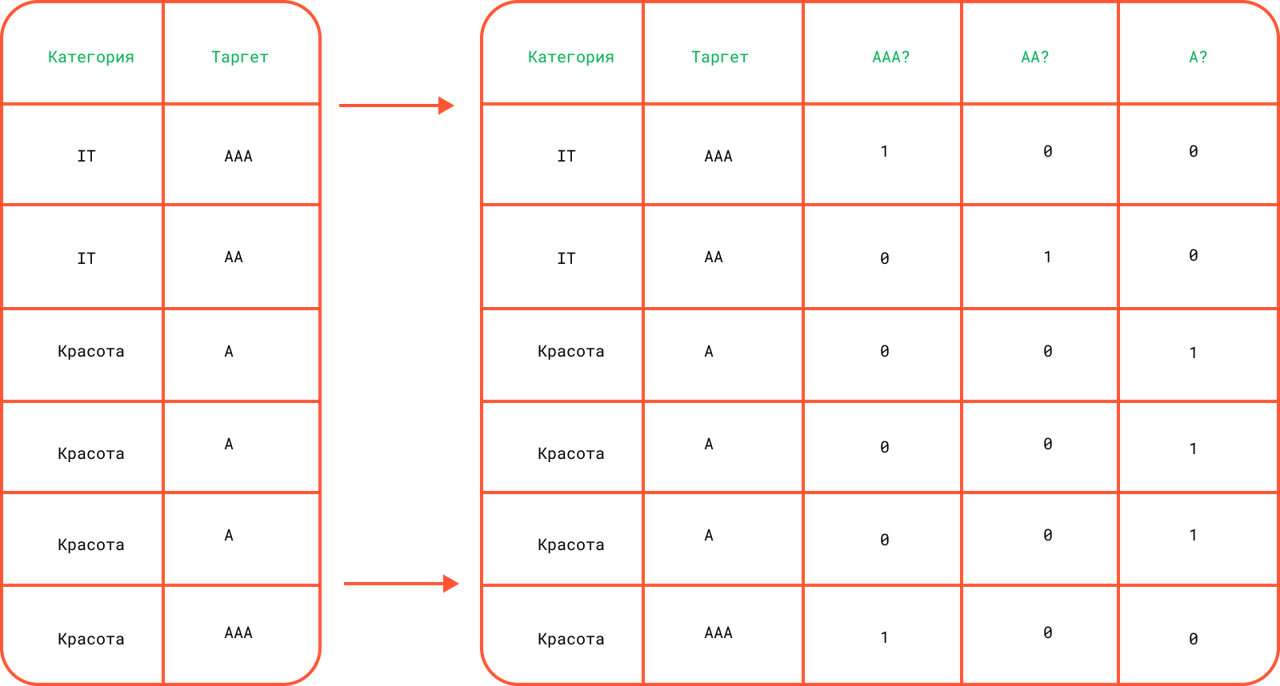

Для каждой категории посчитаем долю единичек в каждой колонке
Избавимся от одной, чтобы не словить мультиколлинеарность


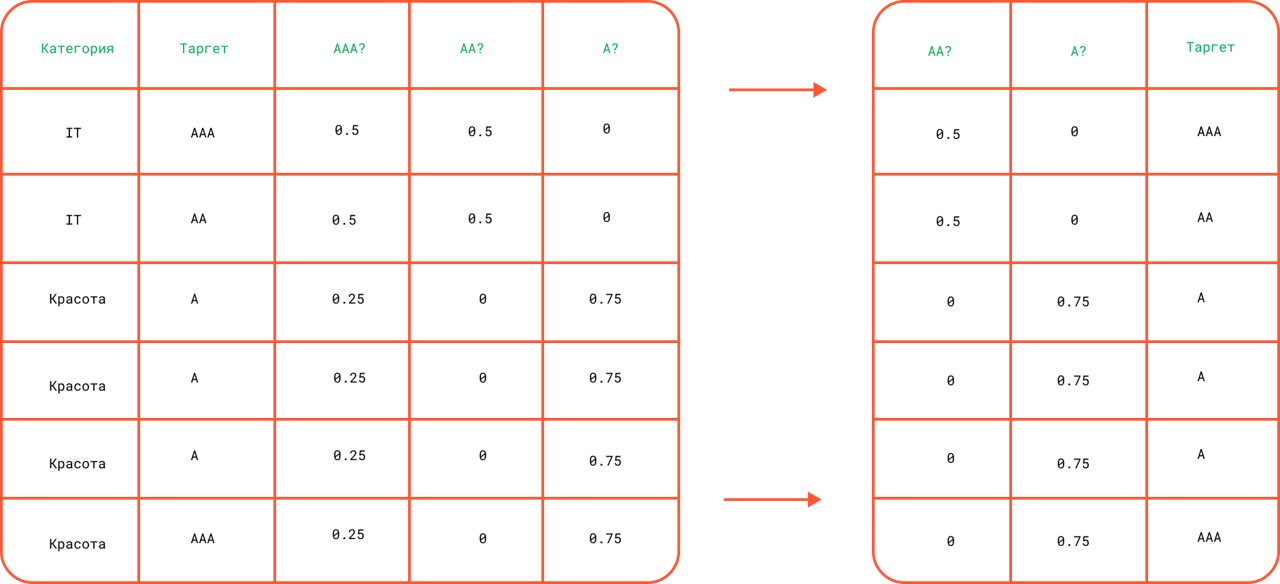

In [52]:
def encode_multiclass_target(df, category, target='Segmentation'):
    df = df[[category, target]].copy()
    target_dummies = pd.get_dummies(df[target],prefix=category,drop_first=True)
    df = pd.concat((df, target_dummies), axis=1)
    for tg in target_dummies.columns:
        df[tg] = df.groupby(category)[tg].transform("mean")
    return df.drop(category, axis=1)

In [55]:
encode_multiclass_target(df, 'Profession')

,Segmentation,Profession_B,Profession_C,Profession_D
ID,,,,
462809,D,0.075826,0.109610,0.734985
462643,A,0.270386,0.107296,0.251788
466315,B,0.270386,0.107296,0.251788
461735,B,0.253612,0.224719,0.205457
462669,A,0.232877,0.155954,0.226554
...,...,...,...,...
464018,D,0.294697,0.410227,0.071212
464685,D,0.305509,0.292154,0.193656
465406,D,0.075826,0.109610,0.734985


In [54]:
df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4716,5010,2640,4878,5314,2268


In [56]:
for col in categorical.drop("Segmentation"):
    if df[col].nunique() < 3:
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True, dtype='int')
        df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)
    else:
        mean_target = encode_multiclass_target(df, col).drop("Segmentation", axis=1)
        df = pd.concat((df.drop(col, axis=1), mean_target), axis=1)

In [57]:
df.head()

,Age,Work_Experience,Family_Size,Segmentation,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_B,Spending_Score_C,Spending_Score_D,Var_1_B,Var_1_C,Var_1_D
ID,,,,,,,,,,,,,,,,
462809,22,1.000000,4.0,D,1,0,0,0.075826,0.109610,0.734985,0.181222,0.135711,0.404674,0.213039,0.100092,0.381084
462643,38,2.378582,3.0,A,0,1,1,0.270386,0.107296,0.251788,0.298886,0.457447,0.069909,0.213039,0.100092,0.381084
466315,67,1.000000,1.0,B,0,1,1,0.270386,0.107296,0.251788,0.181222,0.135711,0.404674,0.234287,0.285472,0.248400
461735,67,0.000000,2.0,B,1,1,1,0.253612,0.224719,0.205457,0.315789,0.333059,0.128289,0.234287,0.285472,0.248400
462669,40,2.378582,6.0,A,0,1,1,0.232877,0.155954,0.226554,0.315789,0.333059,0.128289,0.234287,0.285472,0.248400


### Разделяем данные на признаки и таргет

In [58]:
X = df.drop('Segmentation', axis=1)
Y = df['Segmentation']

### Применим подход one vs all!

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    random_state=0,
                                                    test_size=0.2)

In [61]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

### SGDClassifier(loss='log') ### или hinge - тогда SVM SGDClassifier(loss='log')

pipe = Pipeline([("scaler", StandardScaler()),
                 ("one_vs_all", OneVsRestClassifier(SGDClassifier(loss='log_loss')))])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=SGDClassifier(loss='log_loss')))])

In [64]:
print(f"""F-мера равно: {f1_score(Y_test,
                                  pipe.predict(X_test),
                                  average='macro'):.3f}""" )

F-мера равно: 0.471


In [65]:
pipe.named_steps.one_vs_all.get_params()

{'estimator__alpha': 0.0001,
 'estimator__average': False,
 'estimator__class_weight': None,
 'estimator__early_stopping': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.0,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'optimal',
 'estimator__loss': 'log_loss',
 'estimator__max_iter': 1000,
 'estimator__n_iter_no_change': 5,
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__tol': 0.001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': SGDClassifier(loss='log_loss'),
 'n_jobs': None,
 'verbose': 0}

#### Подберем параметры

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'one_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber',
                                    'squared_hinge', 'perceptron'],

    'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],

    'one_vs_all__estimator__alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

test_fold = [0 if x in X_train.index else -1 for x in X.index]
ps = PredefinedSplit(test_fold)

search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X, Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.49334):
{'one_vs_all__estimator__alpha': 0.01, 'one_vs_all__estimator__loss': 'modified_huber', 'one_vs_all__estimator__penalty': 'l1'}


### Применим подход all vs all!

In [67]:
from sklearn.multiclass import OneVsOneClassifier

pipe_all_all = Pipeline([("scaler", StandardScaler()),
                         ("all_vs_all", OneVsOneClassifier(SGDClassifier(loss='log_loss')))])

pipe_all_all.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('all_vs_all',
                 OneVsOneClassifier(estimator=SGDClassifier(loss='log_loss')))])

#### Результат

In [70]:
print(f"""F-мера равно: {f1_score(Y_test,
                                  pipe_all_all.predict(X_test),
                                  average='macro'):.3f}""" )

F-мера равно: 0.458


#### Подберем параметры

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'all_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber',
                                    'squared_hinge', 'perceptron'],

    'all_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],

    'all_vs_all__estimator__alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

search = GridSearchCV(pipe_all_all, param_grid)

search.fit(X, Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.50310):
{'all_vs_all__estimator__alpha': 0.01, 'all_vs_all__estimator__loss': 'modified_huber', 'all_vs_all__estimator__penalty': 'l2'}


### Метрики моделей (Macro vs. Micro)

#### Macro

In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score


print(f"""Precision равно: {precision_score(Y_test,
                                            pipe_all_all.predict(X_test),
                                            average='macro'):.3f}""" )

print(f"""Recall равно: {recall_score(Y_test,
                                      pipe_all_all.predict(X_test),
                                      average='macro'):.3f}""" )

print(f"""F-мера равно: {f1_score(Y_test,
                                  pipe_all_all.predict(X_test),
                                  average='macro'):.3f}""" )

Precision равно: 0.461
Recall равно: 0.464
F-мера равно: 0.458


#### Micro

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"""Precision равно: {precision_score(Y_test,
                                            pipe_all_all.predict(X_test),
                                            average='micro'):.3f}""" )

print(f"""Recall равно: {recall_score(Y_test,
                                      pipe_all_all.predict(X_test),
                                      average='micro'):.3f}""" )

print(f"""F-мера равно: {f1_score(Y_test,
                                  pipe_all_all.predict(X_test),
                                  average='micro'):.3f}""" )

Precision равно: 0.475
Recall равно: 0.475
F-мера равно: 0.475
